In [1]:
install.packages("fable")
install.packages("forecast")
install.packages("tsibble")
install.packages("tidyverse")
install.packages("lubridate")
install.packages("scales")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ggplot2’, ‘quadprog’, ‘BH’, ‘progressr’, ‘ggdist’, ‘anytime’, ‘numDeriv’, ‘fabletools’, ‘Rcpp’, ‘tsibble’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [8]:
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
suppressMessages(library(fable))
suppressMessages(library(forecast))
suppressMessages(library(tsibble))
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(scales))

In [29]:
monthly_employment <- read.csv("PAYNSA.csv")

In [30]:
monthly_employment %>% head()

,DATE,PAYNSA
,<chr>,<int>
1,1939-01-01,29296
2,1939-02-01,29394
3,1939-03-01,29804
4,1939-04-01,29786
5,1939-05-01,30145
6,1939-06-01,30520


In [31]:
library(dplyr)

filtered_df <- monthly_employment %>%
  filter(as.Date(DATE) >= as.Date("1967-01-01") &
         as.Date(DATE) <= as.Date("2019-12-31"))
filtered_df %>% head()

,DATE,PAYNSA
,<chr>,<int>
1,1967-01-01,64439
2,1967-02-01,64377
3,1967-03-01,64741
4,1967-04-01,65144
5,1967-05-01,65540
6,1967-06-01,66451


I have filtered the data for US monthly employement from 1967-2019 as the weekly jobless claims starts from 1967.

In [10]:
filtered_df <- filtered_df %>%
  filter(PAYNSA != '.') %>%
  mutate(DATE = as.Date(DATE), PAYNSA = as.numeric(PAYNSA)) %>%
  mutate(MDT = floor_date(DATE, 'month')) %>%
  group_by(MDT) %>%
  arrange(desc(DATE)) %>%
  mutate(INDEX = row_number()) %>%
  ungroup() %>%
  filter(INDEX == 1, DATE < as.Date('2019-12-31')) %>%
  select(MDT,PAYNSA) %>%
  arrange(MDT)

me <- ts(filtered_df$PAYNSA, start=c(1967,1), frequency = 12)

In [11]:
me %>% head()

,Jan,Feb,Mar,Apr,May,Jun
1967,64439,64377,64741,65144,65540,66451


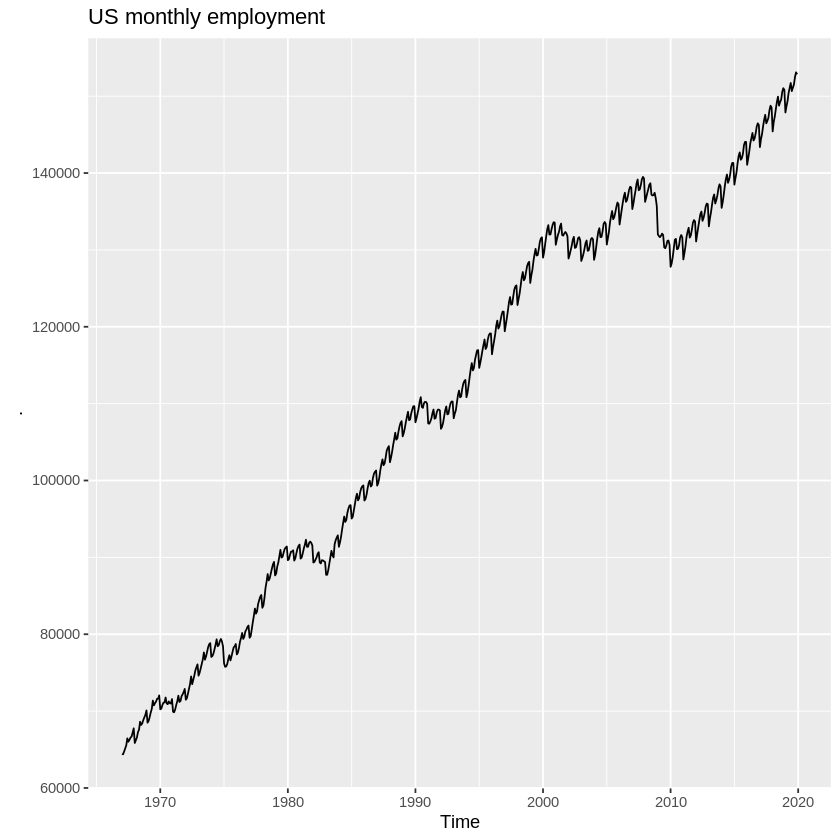

In [12]:
me %>% autoplot() +ggtitle("US monthly employment")

The employment rate seems to be exponentially growing, with seasonality in it.

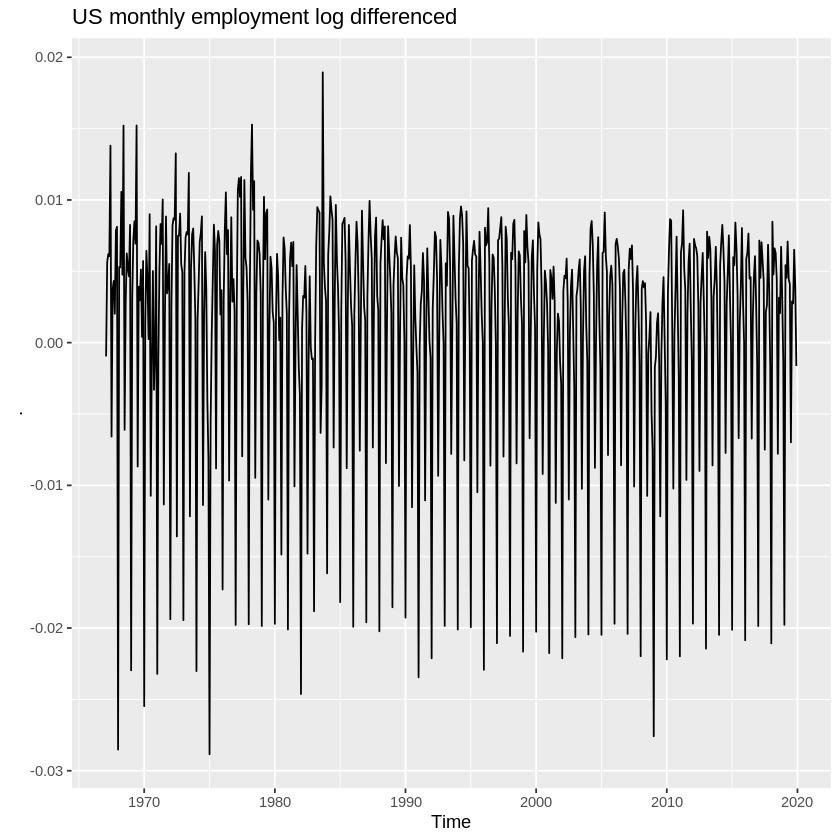

In [13]:
log(me) %>% diff() %>% autoplot() + ggtitle("US monthly employment log differenced")

The log differenced graph is too clumsy to analyze.

In [14]:
me_tsibble <- as_tsibble(me)

In [45]:
me_decomposition <- model(me) %>%
  model(
    stl = classical_decomposition(type = "multiplicative")
  )
me_decomposition

ERROR: Error in UseMethod("model"): no applicable method for 'model' applied to an object of class "ts"


#Weekly jobless claims

In [15]:
jobless <- read.csv("ICNSA.csv")

In [16]:
jobless %>% head()

,DATE,ICNSA
,<chr>,<int>
1,1967-01-07,346000
2,1967-01-14,334000
3,1967-01-21,277000
4,1967-01-28,252000
5,1967-02-04,274000
6,1967-02-11,276000


In [17]:
filtered <- jobless %>%
  filter(as.Date(DATE) <= as.Date("2019-12-31"))
filtered %>% head()

,DATE,ICNSA
,<chr>,<int>
1,1967-01-07,346000
2,1967-01-14,334000
3,1967-01-21,277000
4,1967-01-28,252000
5,1967-02-04,274000
6,1967-02-11,276000


In [18]:
jobless_calender <- jobless %>%
  filter(ICNSA != '.') %>%
  mutate(mdt = floor_date(ymd(DATE),'month')) %>%
  group_by(mdt) %>%
  summarise(claims=sum(as.numeric(ICNSA)), Days=n(), .groups='drop') %>%
  mutate(AverageDaily = claims/Days) %>%
  as_tsibble(index='mdt') %>%
  filter_index(. ~ "2019 Dec")

jobless_calender %>% head()

mdt,claims,Days,AverageDaily
<date>,<dbl>,<int>,<dbl>
1967-01-01,1209000,4,302250
1967-02-01,1045000,4,261250
1967-03-01,1006000,4,251500
1967-04-01,1197000,5,239400
1967-05-01,756000,4,189000
1967-06-01,717000,4,179250


In [19]:
ts_jobless <- ts(jobless_calender$claims, start = c(1967, 1), frequency = 52)

In [20]:
ts_jobless %>% head()

A Time Series:
[1] 1209000 1045000 1006000 1197000  756000  717000

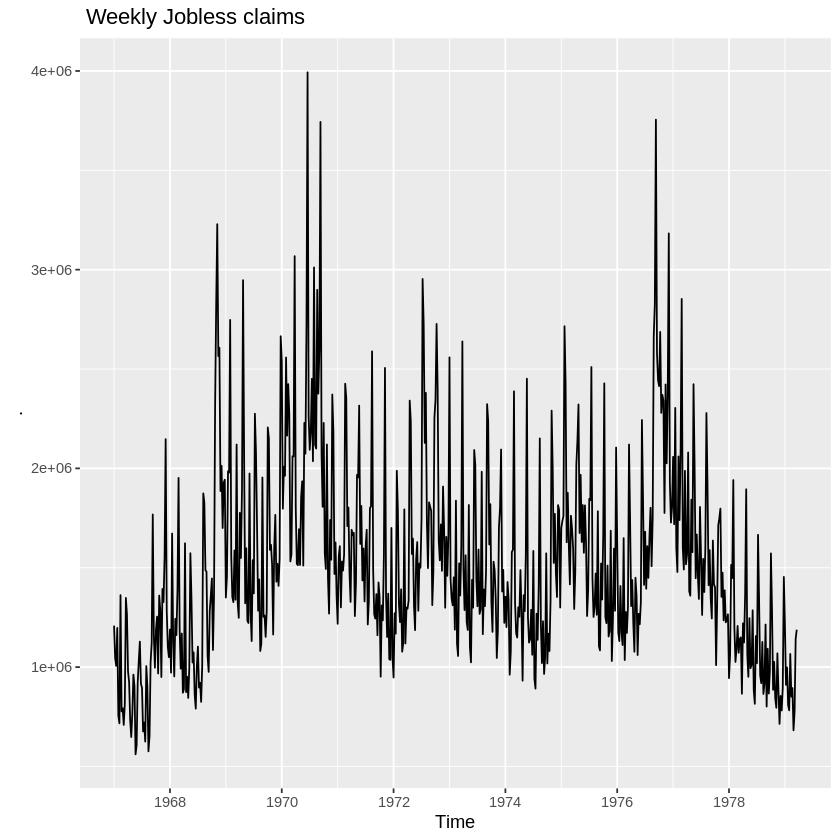

In [21]:
ts_jobless %>% autoplot() + ggtitle(" Weekly Jobless claims")

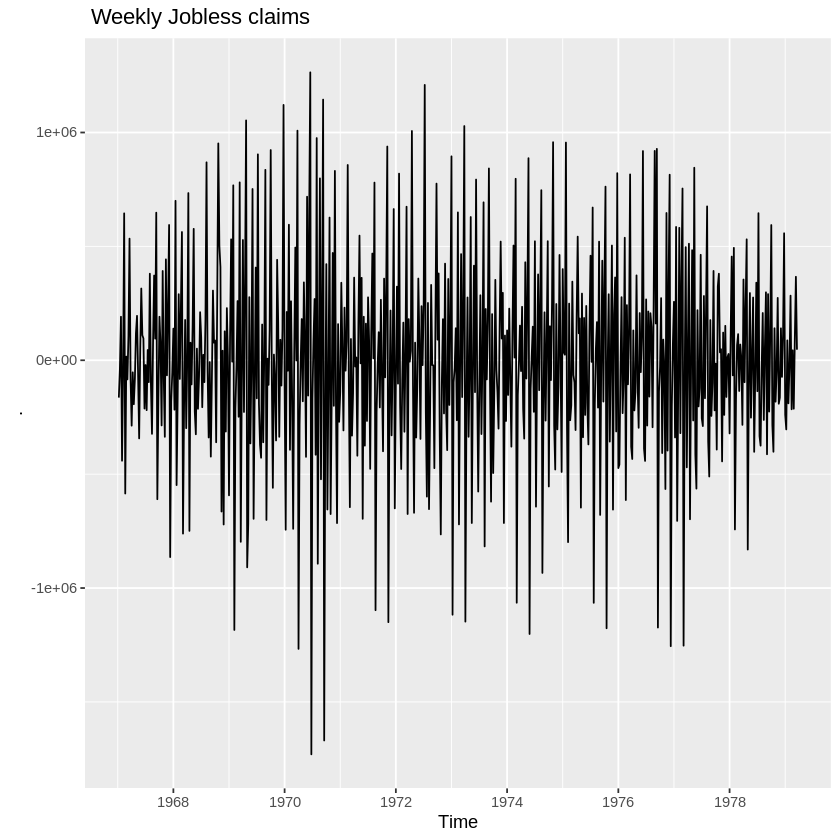

In [22]:
ts_jobless %>% diff() %>% autoplot() + ggtitle(" Weekly Jobless claims")

The weekly data seems to be linear, with a good amount of seasonality in it.

Combining the jobless claims into the employment model

In [23]:
monthly_jobless <- jobless_calender %>%
  summarise(claims = sum(claims), .groups = "drop") %>%
  as_tsibble(index = mdt)

In [24]:
monthly_jobless <- monthly_jobless %>%
  rename(DATE = mdt)

In [25]:
monthly_jobless %>% head()

DATE,claims
<date>,<dbl>
1967-01-01,1209000
1967-02-01,1045000
1967-03-01,1006000
1967-04-01,1197000
1967-05-01,756000
1967-06-01,717000


In [32]:
filtered_df <- filtered_df %>%
  mutate(DATE = as.Date(DATE))

In [73]:
combined_data <- full_join(filtered_df, monthly_jobless, by = "DATE")

In [74]:
combined_data %>% head()

,DATE,PAYNSA,claims
,<date>,<int>,<dbl>
1,1967-01-01,64439,1209000
2,1967-02-01,64377,1045000
3,1967-03-01,64741,1006000
4,1967-04-01,65144,1197000
5,1967-05-01,65540,756000
6,1967-06-01,66451,717000


Here, I have summarized the claims of each month and joined the two into one combined dataframe to use for the forecasts.

In [35]:
ts_jobless <- as_tsibble(ts_jobless)

Warning message:
“Expected frequency of weekly data: 365.25 / 7 (approx 52.18), not  52.”


In [37]:
library(forecast)
jobless_decomposition <- ts_jobless %>% model(stl = classical_decomposition(type='additive'))

ERROR: Error in classical_decomposition(type = "additive"): could not find function "classical_decomposition"


#Forecasts for jobless claims

In [51]:
jobless_training <- ts_jobless %>% filter_index(. ~ "2018 Dec")
jobless_test <- ts_jobless %>% filter_index("2019 Jan" ~ .)

In [52]:
print(jobless_training)

# A tsibble: 636 x 2 [1s] <UTC>
   index                 value
   <dttm>                <dbl>
 1 1967-01-01 00:00:00 1209000
 2 1967-01-08 00:27:49 1045000
 3 1967-01-15 00:55:38 1006000
 4 1967-01-22 01:22:55 1197000
 5 1967-01-29 01:50:44  756000
 6 1967-02-05 02:18:33  717000
 7 1967-02-12 02:46:21 1362000
 8 1967-02-19 03:13:39  777000
 9 1967-02-26 03:41:27  793000
10 1967-03-05 04:09:16  709000
# ℹ 626 more rows


In [80]:
#mean forecasts
mean_model <- jobless_training %>% model(MEAN(value))
mean_forecasts <- mean_model %>% forecast(jobless_test)

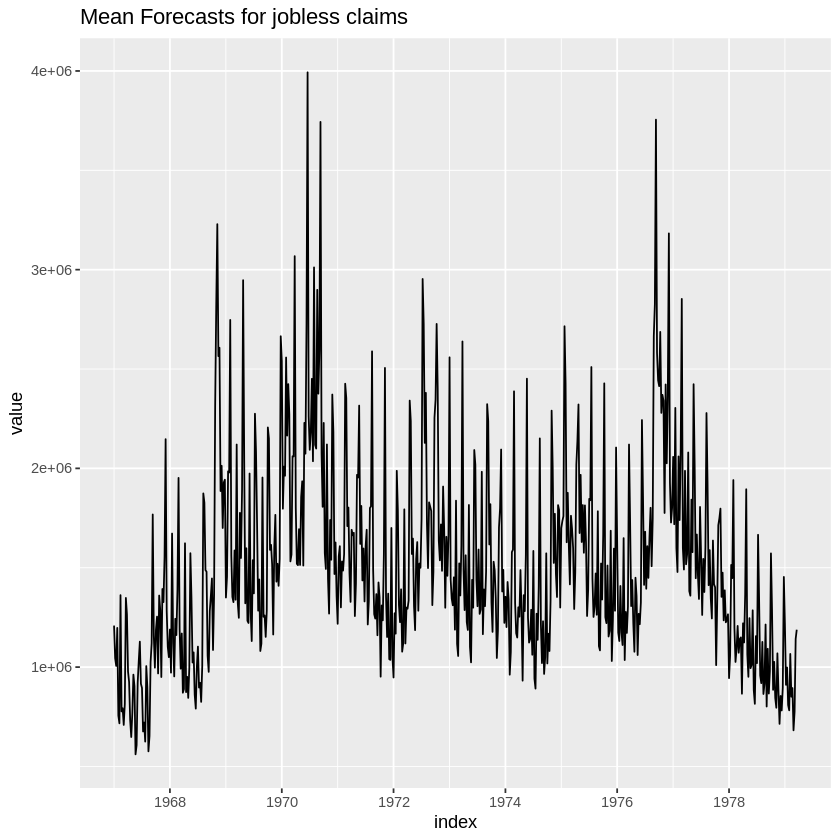

In [54]:
mean_forecasts %>% autoplot(jobless_training) + ggtitle('Mean Forecasts for jobless claims') +
  autolayer(jobless_test, value)

ggsave(paste('mean_forecats.png',sep='_'), height = 4, width =5)

Warning message:
“1 error encountered for NAIVE(value)
[1] .data contains implicit gaps in time. You should check your data and convert implicit gaps into explicit missing values using `tsibble::fill_gaps()` if required.
”


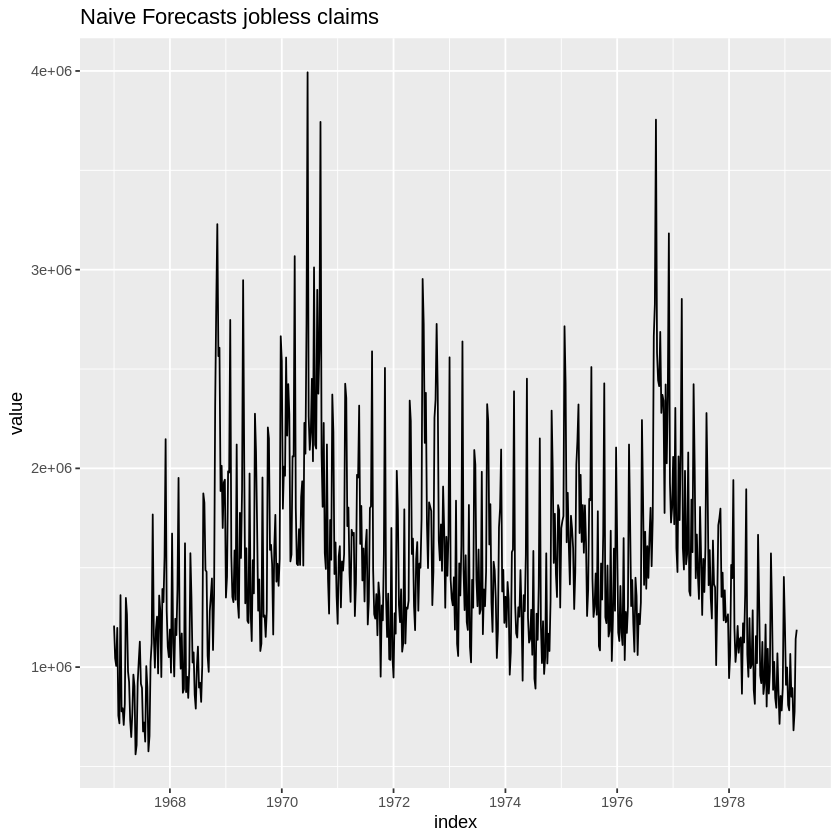

In [79]:
#naive forecasts
naive_model <- jobless_training %>% model(NAIVE(value))
naive_forecasts <- naive_model %>% forecast(jobless_test)

naive_forecasts %>% autoplot(jobless_training) + ggtitle('Naive Forecasts jobless claims') +
  autolayer(jobless_test, value)

ggsave(paste('ap_naive.png', sep='_'), height = 4, width =6)

Warning message:
“1 error encountered for SNAIVE(value ~ lag("year"))
[1] .data contains implicit gaps in time. You should check your data and convert implicit gaps into explicit missing values using `tsibble::fill_gaps()` if required.
”


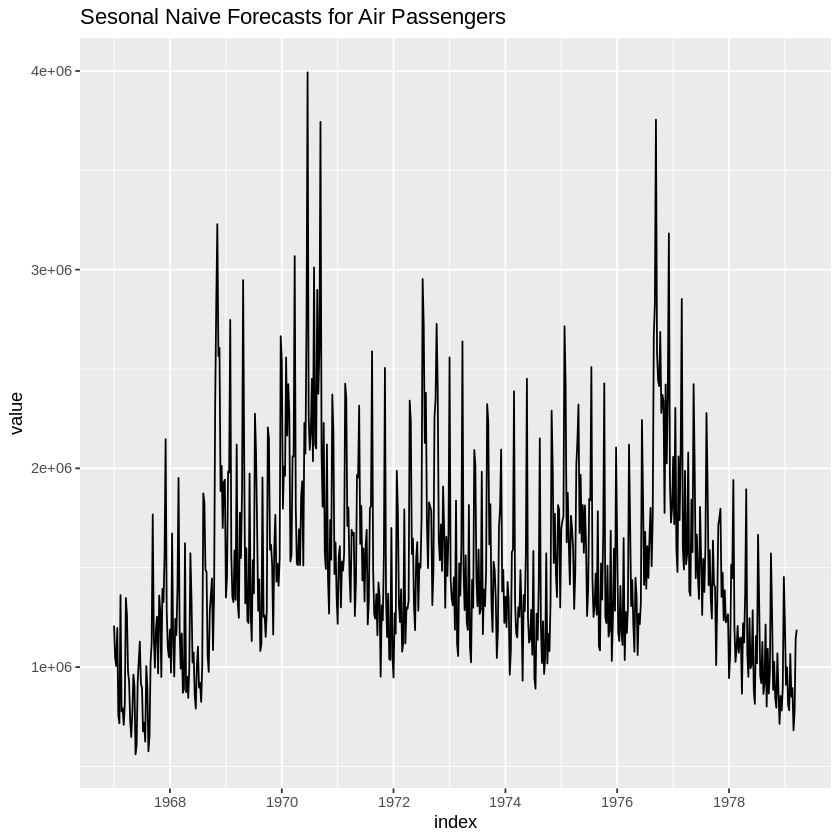

In [56]:
# Seasonal Naive Forecast - Baseline
snaive_model <- jobless_training %>% model(SNAIVE(value ~ lag("year")))
snaive_forecasts <- snaive_model %>% forecast(jobless_test)

snaive_forecasts %>% autoplot(jobless_training) + ggtitle('Sesonal Naive Forecasts for Air Passengers') +
  autolayer(jobless_test, value)

ggsave(paste( 'jobless_snaive.png', sep='_'), height = 4, width =6)

Warning message:
“1 error encountered for RW(value ~ drift())
[1] .data contains implicit gaps in time. You should check your data and convert implicit gaps into explicit missing values using `tsibble::fill_gaps()` if required.
”


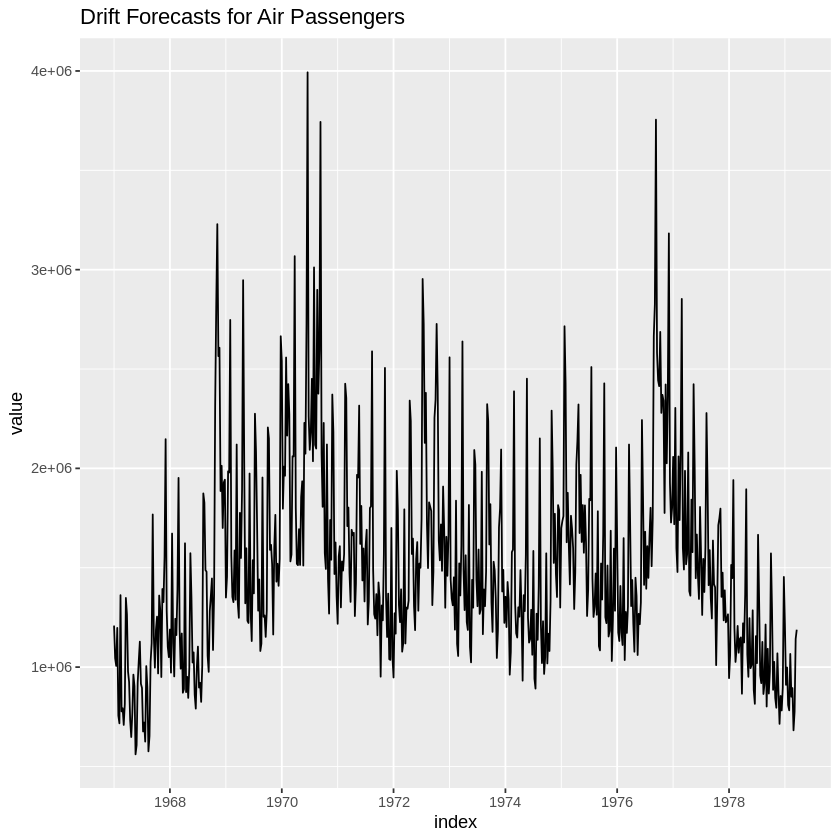

In [57]:
# Drift Forecast - Baseline
drift_model <- jobless_training %>% model(RW(value ~ drift()))
drift_forecasts <- drift_model %>% forecast(jobless_test)

drift_forecasts %>% autoplot(jobless_training) + ggtitle('Drift Forecasts for Air Passengers') +
  autolayer(jobless_test, value)

ggsave(paste('ap_drift.png', sep='_'), height = 4, width =6)

For some reason i cannot see the autolayer plotted so I cannot predict which is better for the claims.

#Forecasts for employment

In [75]:
combined_data <- combined_data %>%
  filter(PAYNSA != '.') %>%
  filter(claims != '.') %>%
  mutate(DATE = as.Date(DATE), PAYNSA = as.numeric(PAYNSA), claims = as.numeric(claims)) %>%
  mutate(MDT = floor_date(DATE, 'month')) %>%
  group_by(MDT) %>%
  arrange(desc(DATE)) %>%
  mutate(INDEX = row_number()) %>%
  ungroup() %>%
  filter(INDEX == 1, DATE < as.Date('2019-12-31')) %>%
  select(MDT,PAYNSA,claims) %>%
  arrange(MDT)

ts_data <- ts(combined_data$PAYNSA, start=c(1967,1), frequency = 12)

In [76]:
ts_data %>% head()

,Jan,Feb,Mar,Apr,May,Jun
1967,64439,64377,64741,65144,65540,66451


In [77]:
ts_data_final <- as_tsibble(ts_data)

In [78]:
emp_training <- ts_data_final %>% filter_index(. ~ "2018 Dec")
emp_test <- ts_data_final %>% filter_index("2019 Jan" ~ .)

In [81]:
emp_training %>% head()

index,value
<mth>,<dbl>
1967 Jan,64439
1967 Feb,64377
1967 Mar,64741
1967 Apr,65144
1967 May,65540
1967 Jun,66451


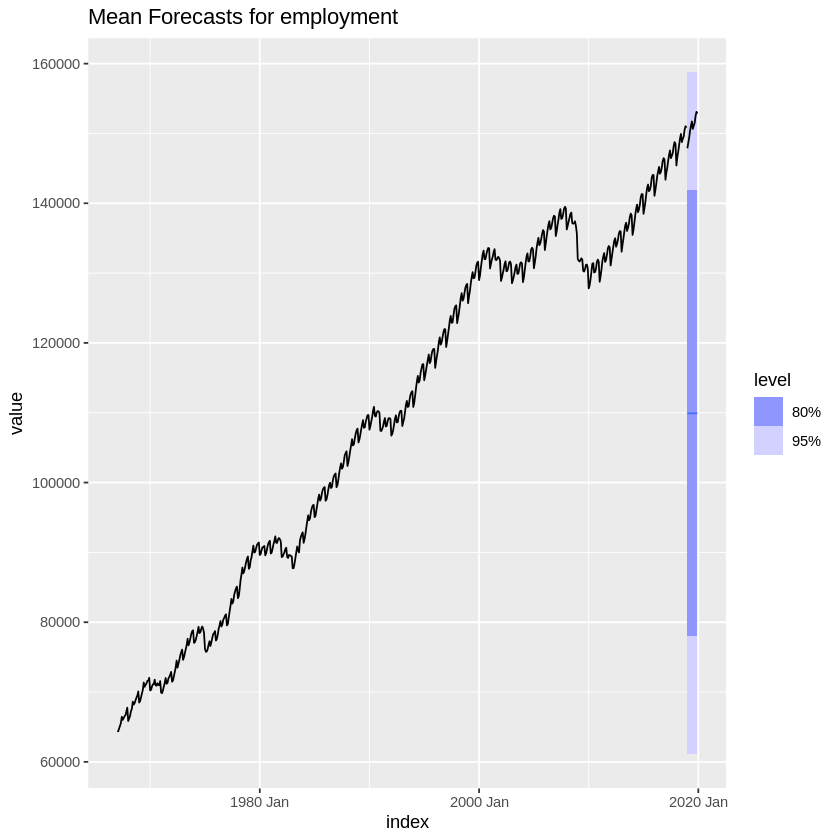

In [82]:
#mean forecasts
mean_model <- emp_training %>% model(MEAN(value))
mean_forecasts <- mean_model %>% forecast(emp_test)

mean_forecasts %>% autoplot(emp_training) + ggtitle('Mean Forecasts for employment') +
  autolayer(emp_test, value)

ggsave(paste('mean_forecsats_employment.png',sep='_'), height = 4, width =5)

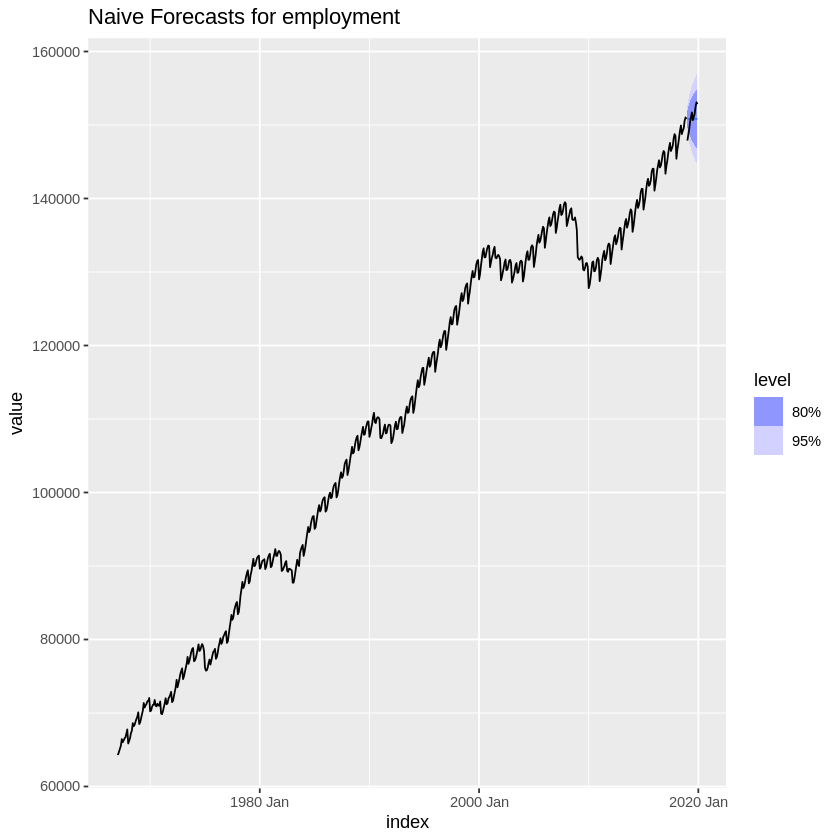

In [84]:
#naive forecasts
naive_model <- emp_training %>% model(NAIVE(value))
naive_forecasts <- naive_model %>% forecast(emp_test)

naive_forecasts %>% autoplot(emp_training) + ggtitle('Naive Forecasts for employment') +
  autolayer(emp_test, value)

ggsave(paste('employment_naive.png', sep='_'), height = 4, width =6)

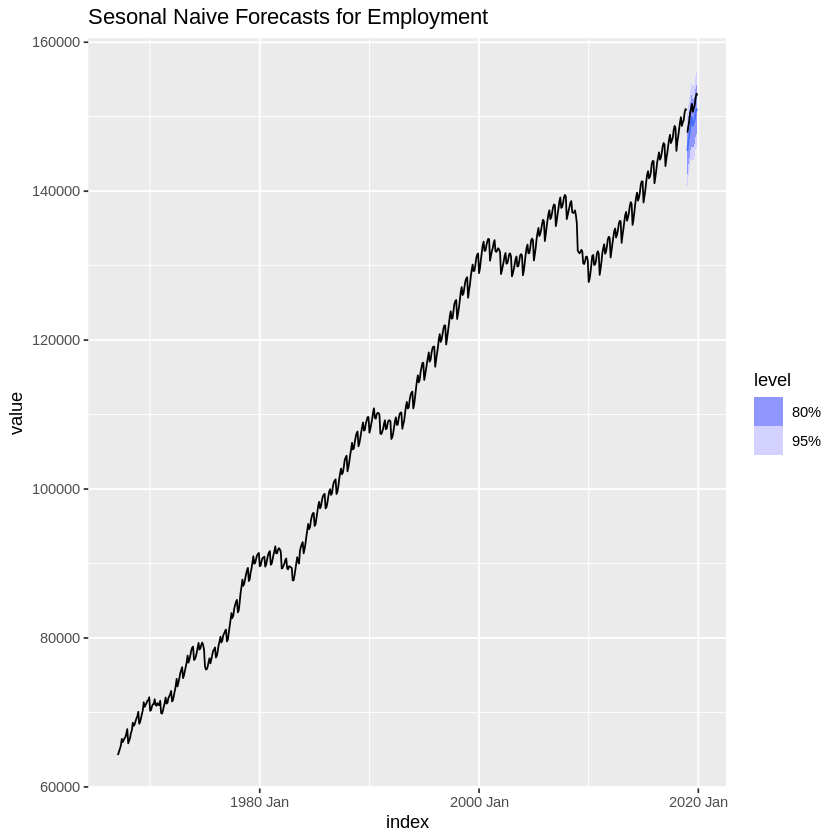

In [85]:
# Seasonal Naive Forecast - Baseline
snaive_model <- emp_training %>% model(SNAIVE(value ~ lag("year")))
snaive_forecasts <- snaive_model %>% forecast(emp_test)

snaive_forecasts %>% autoplot(emp_training) + ggtitle('Sesonal Naive Forecasts for Employment') +
  autolayer(emp_test, value)

ggsave(paste( 'employment_snaive.png', sep='_'), height = 4, width =6)

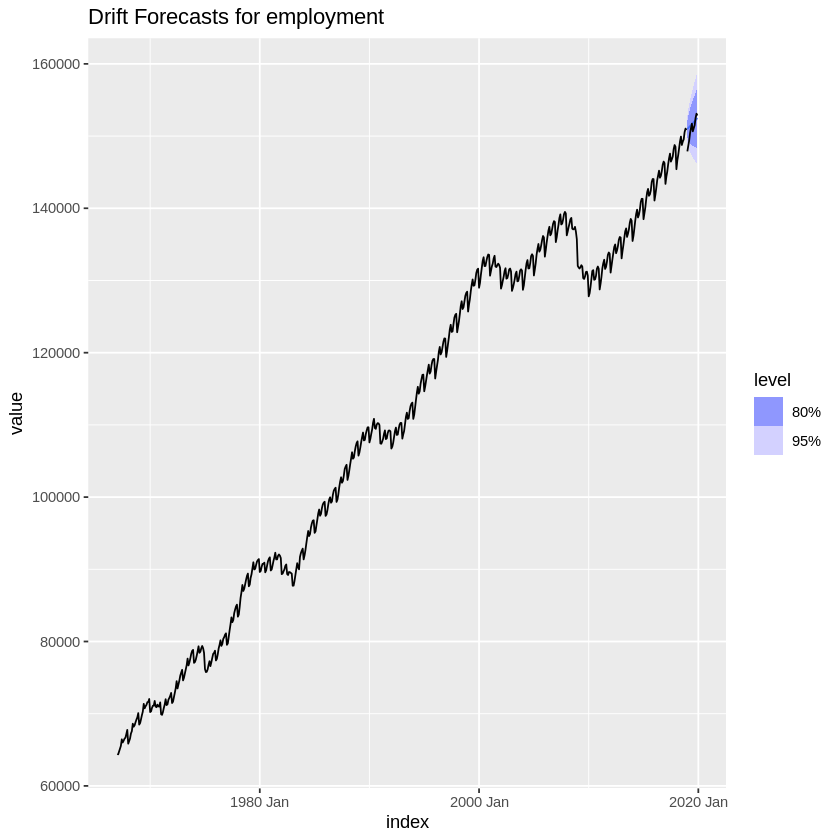

In [86]:
# Drift Forecast - Baseline
drift_model <- emp_training %>% model(RW(value ~ drift()))
drift_forecasts <- drift_model %>% forecast(emp_test)

drift_forecasts %>% autoplot(emp_training) + ggtitle('Drift Forecasts for employment') +
  autolayer(emp_test, value)

ggsave(paste('employment_drift.png', sep='_'), height = 4, width =6)

The mean method does not seem to be giving forecasts properly, but the naive and drift methods seem to be more accurate. The seasonal naive captures the seasonality as well.

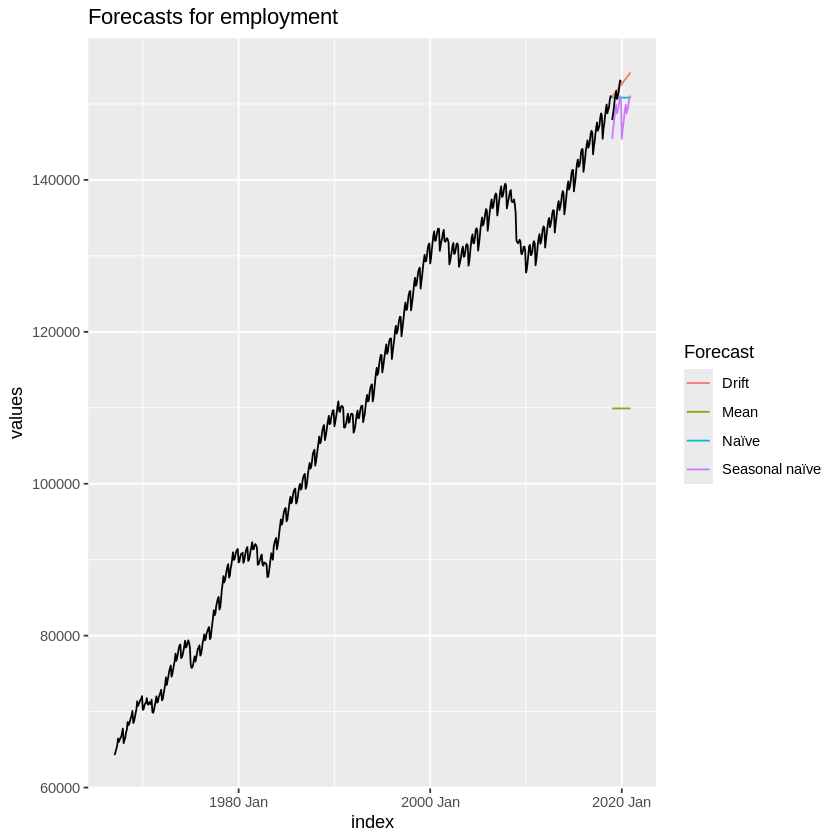

In [87]:
emp_fit <- emp_training |>
  model(
    Mean = MEAN(value),
    `Naïve` = NAIVE(value),
    `Seasonal naïve` = SNAIVE(value ~ lag('year')),
    Drift = RW(value ~ drift())
  )

emp_fc <- emp_fit |> forecast(h = 24)

emp_fc |>
  autoplot(emp_training, level = NULL) +
  autolayer(emp_test, value,
    colour = "black"
  ) +
  labs(
    y = "values",
    title = "Forecasts for employment"
  ) +
  guides(colour = guide_legend(title = "Forecast"))

  ggsave(paste('employment_basic_forecast_comp.png', sep='_'), height = 4, width =6)

The naive method seems to be capturing the trend better than the other methods.

In [90]:
fabletools::accuracy(emp_fc, combined_data)

ERROR: Error in UseMethod("key_vars"): no applicable method for 'key_vars' applied to an object of class "c('tbl_df', 'tbl', 'data.frame')"
